# Hospital Operations – Admission Prediction EDA + Baseline Models

## Objective
Explore whether operational and demographic features contain predictive signal for hospital admission, and build baseline ML models.

## Dataset layers
- Bronze: raw CSV
- Silver: cleaned parquet
- Gold: DuckDB star schema (used in training pipeline)

This notebook focuses on analysis and baseline model comparison (LogReg vs RandomForest).


In [15]:
# imports 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report, RocCurveDisplay, ConfusionMatrixDisplay

from pathlib import Path

FIGURES_DIR = Path("../reports/figures")
FIGURES_DIR.mkdir(parents=True, exist_ok=True)




In [16]:
# Load Silver data

df = pd.read_parquet("../data/processed/encounters_clean.parquet")
df.head()

,patient_id,admission_date,admission_time,merged_datetime,gender,age,race,department,satisfaction_score,wait_time_minutes,arrival_datetime,event_datetime,event_date,event_hour,event_dayofweek,event_month,admitted
0,780-96-6113,9/9/2024,9:25:00 AM,NaT,Female,63,African American,nan,5.0,32,2024-09-09 09:25:00,2024-09-09 09:25:00,2024-09-09,9.0,0.0,9.0,0
1,714-35-6722,9/9/2024,4:42:00 PM,NaT,Male,31,Asian,Orthopedics,NaN,22,2024-09-09 16:42:00,2024-09-09 16:42:00,2024-09-09,16.0,0.0,9.0,0
2,571-85-3714,9/9/2024,12:14:00 AM,NaT,Male,75,White,General Practice,NaN,16,2024-09-09 00:14:00,2024-09-09 00:14:00,2024-09-09,0.0,0.0,9.0,0
3,404-43-9499,9/9/2024,8:33:00 PM,NaT,Male,79,African American,General Practice,NaN,38,2024-09-09 20:33:00,2024-09-09 20:33:00,2024-09-09,20.0,0.0,9.0,1
4,552-51-5855,9/9/2024,7:25:00 PM,NaT,Female,24,African American,nan,NaN,36,2024-09-09 19:25:00,2024-09-09 19:25:00,2024-09-09,19.0,0.0,9.0,1


In [17]:
# Quick checks

print("Shape:", df.shape)
df[["admitted","age","wait_time_minutes","department","gender","race","event_hour","event_dayofweek","event_month"]].head()

Shape: (9216, 17)


,admitted,age,wait_time_minutes,department,gender,race,event_hour,event_dayofweek,event_month
0,0,63,32,nan,Female,African American,9.0,0.0,9.0
1,0,31,22,Orthopedics,Male,Asian,16.0,0.0,9.0
2,0,75,16,General Practice,Male,White,0.0,0.0,9.0
3,1,79,38,General Practice,Male,African American,20.0,0.0,9.0
4,1,24,36,nan,Female,African American,19.0,0.0,9.0


In [18]:
df["admitted"].value_counts(dropna=False)

admitted
1    4612
0    4604
Name: count, dtype: int64

## EDA Highlights
We examine:
- Target distribution (admitted)
- Wait time vs admission
- Admission rates by department
- Time pattern signals (hour/day/month)


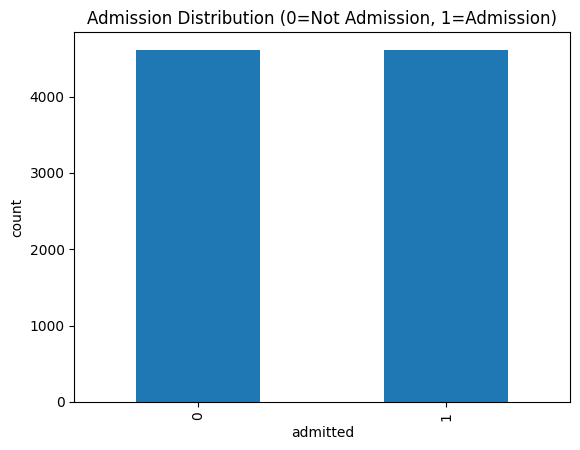

In [19]:
# Target distribution plot

df["admitted"].value_counts().sort_index().plot(kind="bar")
plt.title("Admission Distribution (0=Not Admission, 1=Admission)")
plt.xlabel("admitted")
plt.ylabel("count")

plt.savefig(FIGURES_DIR / "admission_distribution.png", dpi=300, bbox_inches="tight")
plt.show()


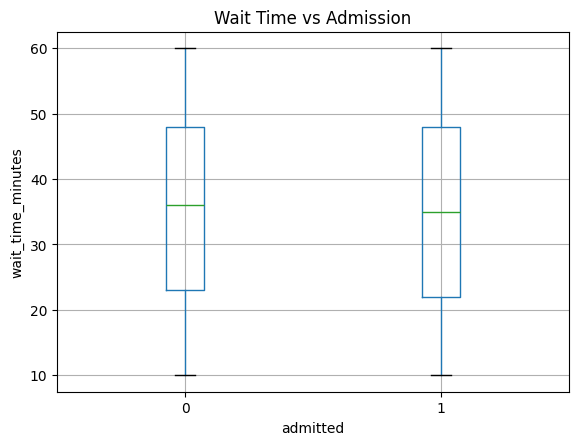

In [20]:
# Wait time vs admission

df.boxplot(column="wait_time_minutes", by="admitted")
plt.title("Wait Time vs Admission")
plt.suptitle("")
plt.xlabel("admitted")
plt.ylabel("wait_time_minutes")

plt.savefig(FIGURES_DIR / "wait_time_vs_admission.png", dpi=300, bbox_inches="tight")
plt.show()


In [21]:
# Admission rate by department



dept_rate = (
    df[df["department"].notna() & (df["department"].str.lower() !="nan")] # Missing department values were stored as string "nan" during cleaning and were excluded from analysis.

      .groupby("department")["admitted"]
      .mean()
      .sort_values(ascending=False)
)


dept_rate.head(10)

department
Renal               0.534884
Neurology           0.502591
Orthopedics         0.500503
Gastroenterology    0.500000
Physiotherapy       0.496377
Cardiology          0.491935
General Practice    0.482065
Name: admitted, dtype: float64

Note: Missing department values were stored as string "nan" during cleaning and were excluded from analysis.


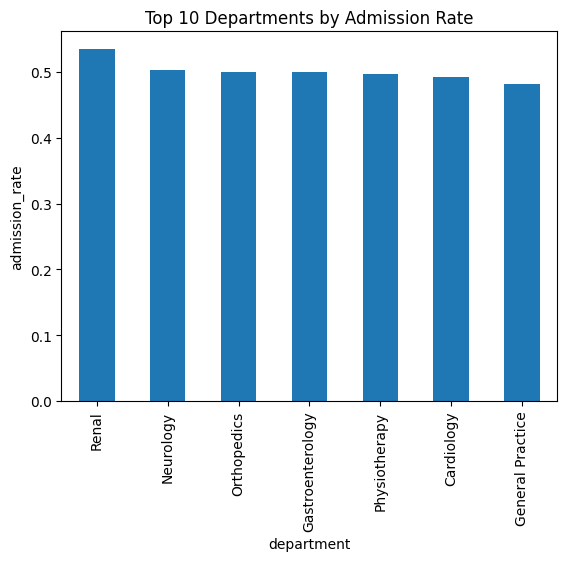

In [22]:
# Top 10 department bar chart

dept_rate.head(10).plot(kind="bar")
plt.title("Top 10 Departments by Admission Rate")
plt.xlabel("department")
plt.ylabel("admission_rate")

plt.savefig(FIGURES_DIR / "admission_rate_by_department_top10.png", dpi=300, bbox_inches="tight")
plt.show()


# Baseline ML Models

We compare two models:
1. Logistic Regression (strong baseline, interpretable)
2. Random Forest (non-linear baseline)

Features used (available around arrival time):
- age
- wait_time_minutes
- event_hour, event_dayofweek, event_month
- department, gender, race

Evaluation:
- ROC-AUC
- Confusion Matrix (threshold=0.5)
- Classification Report


In [23]:
# Prepare feature matrix

features = [
    "age",
    "wait_time_minutes",
    "event_hour",
    "event_dayofweek",
    "event_month",
    "department",
    "gender",
    "race"
]

target = "admitted"

df_model = df[features + [target]].dropna(subset=[target]).copy()

X = df_model[features]
y = df_model[target].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train.shape, X_test.shape

((7372, 8), (1844, 8))

In [24]:
# Preprocessing and pipelines

num_features = ["age", "wait_time_minutes", "event_hour", "event_dayofweek", "event_month"]
cat_features = ["department", "gender", "race"]

preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("imp", SimpleImputer(strategy="median"))]), num_features),
        ("cat", Pipeline([
            ("imp", SimpleImputer(strategy="most_frequent")),
            ("ohe", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_features),
    ]
)

pipelines = {
    "log_reg": Pipeline([
        ("prep", preprocess),
        ("model", LogisticRegression(max_iter=1000))
    ]),
    "random_forest": Pipeline([
        ("prep", preprocess),
        ("model", RandomForestClassifier(n_estimators=300, random_state=42, class_weight="balanced"))
    ]),
}


In [25]:
# Train + ROC-AUC comparison

results = {}

for name, pipe in pipelines.items():
    pipe.fit(X_train, y_train)
    proba = pipe.predict_proba(X_test)[:,1]
    auc = roc_auc_score(y_test, proba)
    results[name] = auc
    print(f"{name} ROC-AUC: {auc:.4f}")

results

log_reg ROC-AUC: 0.4905
random_forest ROC-AUC: 0.5155


{'log_reg': 0.49046916595203055, 'random_forest': 0.5155308364006809}

Best model: random_forest
ROC-AUC: 0.5155

Classification report:
              precision    recall  f1-score   support

           0       0.51      0.50      0.50       921
           1       0.51      0.52      0.52       923

    accuracy                           0.51      1844
   macro avg       0.51      0.51      0.51      1844
weighted avg       0.51      0.51      0.51      1844



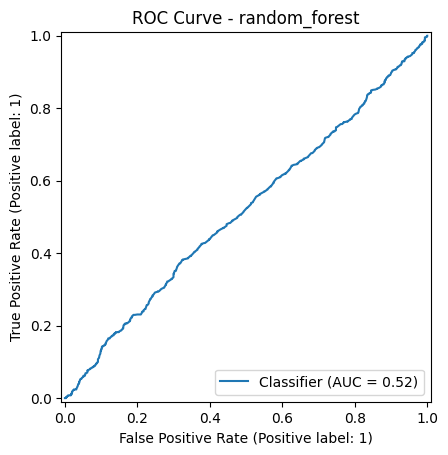

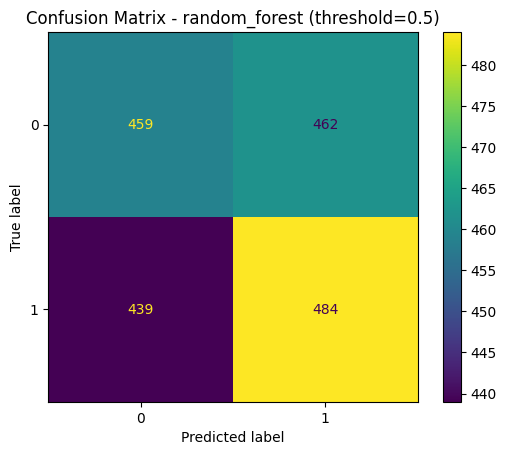

In [26]:
# Pick best model & plot ROC + Confusion Matrix

best_name = max(results, key=results.get)
best_pipe = pipelines[best_name]


best_pipe.fit(X_train, y_train)
best_proba = best_pipe.predict_proba(X_test)[:, 1]
best_pred = (best_proba >= 0.5).astype(int)


print("Best model:", best_name)
print("ROC-AUC:", round(results[best_name], 4))
print("\nClassification report:")
print(classification_report(y_test, best_pred))


RocCurveDisplay.from_predictions(y_test, best_proba)
plt.title(f"ROC Curve - {best_name}")

plt.savefig(FIGURES_DIR / f"roc_curve_{best_name}.png", dpi=300, bbox_inches="tight")
plt.show()



ConfusionMatrixDisplay.from_predictions(y_test, best_pred)
plt.title(f"Confusion Matrix - {best_name} (threshold=0.5)")

plt.savefig(FIGURES_DIR / f"confusion_matrix_{best_name}.png", dpi=300, bbox_inches="tight")
plt.show()


## Baseline Model Results

- Best performing baseline: **Random Forest**
- ROC-AUC: **~0.52** (only slightly above random)

Interpretation:
The available operational/demographic features provide **limited predictive signal** for admission decisions. This is expected in real hospital settings where admission is strongly influenced by clinical severity (triage acuity), diagnosis, vitals, and clinician judgement, which are not available in this dataset.


## Error Analysis (High-level)

From the confusion matrix, false positives and false negatives are both high.
This indicates the model is not separating admitted vs non-admitted cases well.

In a real deployment, we would:
- Review feature availability and potential leakage
- Add clinical predictors (acuity/triage, diagnosis group, vitals)
- Evaluate calibration (probabilities) and choose a threshold based on costs
- Use time-based validation to reflect real-world performance


In [27]:
# Add PR-AUC 

from sklearn.metrics import average_precision_score

ap = average_precision_score(y_test, best_proba)
print("PR-AUC:", round(ap, 4))


PR-AUC: 0.5171


## Conclusion & Next Steps

This notebook demonstrates:
- Operational EDA (wait times, department patterns, time patterns)
- Baseline model comparison (LogReg vs RandomForest)
- Clear evaluation and honest interpretation

Next steps for improved predictive performance:
1. Add richer clinical severity features (triage/acuity)
2. Add diagnosis/complaint categories and prior utilisation signals
3. Use time-based split (train on earlier months, test on later months)
4. Consider gradient boosting and probability calibration
